<a href="https://colab.research.google.com/github/Alf-caput/P4_AlgoritmoGenetico/blob/dev2/P4_AlgGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 4: Algoritmo genético

### Ana Robledano, Miguel Egido, Alfredo Robledano.

1.- Encontrar los máximos de la función "picos"

$$z = f(x,y) = 3(1-x)^2e^{-(x^2)-(y+1)^2}-10(x/5-x^3-y^5)e^{-x^2-y^2}-1/3e^{-(x+1)^2-y^2}$$

En el dominio $$\{x,y\} \in [-100,100]$$


In [23]:
!pip install deap

In [24]:
import random
from deap import base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

random.seed(42)

VALID_RANGE = (-100, 100)
INDIVIDUAL_SIZE = 2
POPULATION_SIZE = 32

toolbox = base.Toolbox()

toolbox.register("attr_uniform", random.uniform, *VALID_RANGE)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_uniform, INDIVIDUAL_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, POPULATION_SIZE)

In [25]:
import math
from functools import partial

F = lambda x, y: 3*(1-x)**2*math.exp(-(x**2)-(y+1)**2)-10*(x/5-x**3-y**5)*math.exp(-x**2-y**2)-1/3*math.exp(-(x+1)**2-y**2)

def evaluate_fit(individual, target_function, gene_range):
    for gene in individual:
        if not (gene_range[0] <= gene <= gene_range[1]):
            return -1,
    return target_function(*individual),

toolbox.register("evaluate", partial(evaluate_fit, target_function=F, gene_range=VALID_RANGE))

In [26]:
MU = 0 # mean
SIGMA = 5 # standard deviation
INDPB = 0.1 # independent probability for each atribute to be mutated
TOURNAMENT_SIZE = 3

toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=MU, sigma=SIGMA, indpb=INDPB)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

In [27]:
from deap import algorithms
import numpy as np

CXPB = 0.5 # probability of mating 2 individuals
MUTPB = 0.2 # probabilty of mutating an individual
NGEN = 20 # number of generations

pop = toolbox.population()
print(type(pop))

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

<class 'list'>
gen	nevals	avg          	std	min          	max
0  	32    	-2.16768e-285	0  	-6.93659e-284	0  
1  	19    	0            	0  	0            	0  
2  	27    	-1.44113e-130	8.02388e-130	-4.61162e-129	0  
3  	17    	0            	0           	0            	0  
4  	20    	0            	0           	0            	0  
5  	19    	0            	0           	0            	0  
6  	18    	0            	0           	0            	0  
7  	17    	0            	0           	0            	0  
8  	20    	0            	0           	0            	0  
9  	13    	0            	0           	0            	0  
10 	20    	0            	0           	0            	0  
11 	21    	0            	0           	0            	0  
12 	18    	0            	0           	0            	0  
13 	23    	0            	0           	0            	0  
14 	18    	0            	0           	0            	0  
15 	18    	0            	0           	0            	0  
16 	19    	-0.03125     	0.173993    	-1           	0  
17 	

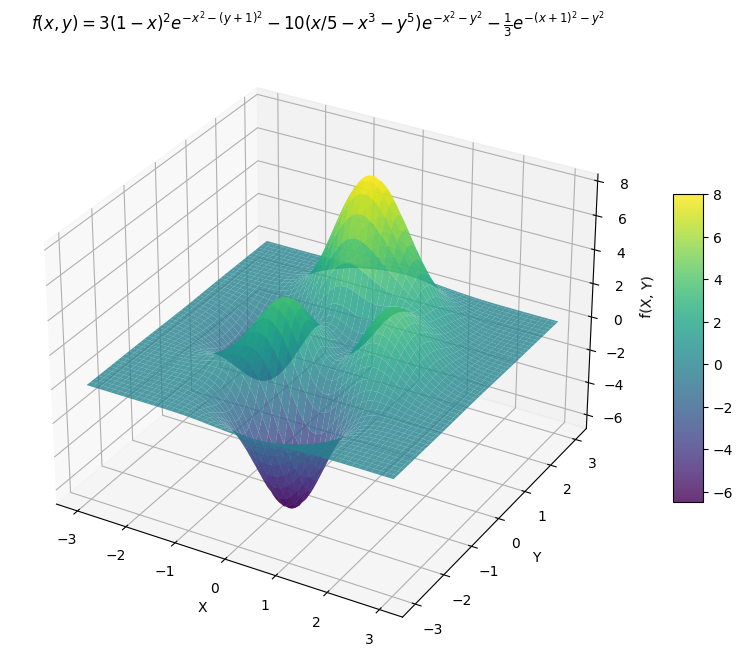

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def f(x, y):
    return 3*(1-x)**2*np.exp(-x**2-(y+1)**2)-10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3*np.exp(-(x+1)**2-y**2)

# Generar valores para x y y
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Crear la figura 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie 3D
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Configurar etiquetas y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X, Y)')
title_text = r'$f(x, y) = 3(1-x)^2e^{-x^2-(y+1)^2} - 10(x/5 - x^3 - y^5)e^{-x^2-y^2} - \frac{1}{3}e^{-(x+1)^2-y^2}$'
ax.set_title(title_text, fontsize=12)
# Añadir barra de colores
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)


plt.show()


2.- Dada la [Función de Rastringin](https://en.wikipedia.org/wiki/Rastrigin_function#:~:text=In%20mathematical%20optimization%2C%20the%20Rastrigin,has%20been%20generalized%20by%20Rudolph.), con A = 10 y  $$\{xi\} \in [-5.12,5.12]$$

Implementa dicha función en Python y minimízala para n=10

Compara el funcionamiento del Algoritmo Genético para cruce con un punto con cruce con dos puntos

### Instalación de librerías para resolver Algoritmos Genéticos con Python

In [28]:
!pip install deap


gen	nevals	min                  	avg    
0  	50    	(114.22792845754344,)	183.441


AttributeError: ignored